# Experiment 5: Small GEI CNN with Subject-Wise Validation

This notebook evaluates a lightweight task-specific CNN trained from scratch on grayscale Gait Energy Images (GEIs). Two experimental modes are demonstrated:

1. **K-Fold Cross-Validation**: 5-fold subject-wise CV for robust hyperparameter validation
2. **Multi-Run Statistical Evaluation**: 30 independent runs with different seeds for statistical significance testing

**Key Features**:
- Subject-wise stratified splitting (prevents data leakage)
- Custom CNN architecture (~1.2M parameters)
- AdamW optimizer with cosine learning rate decay
- Comprehensive visualization suite

**Documentation**:
- Splitting methodology: [SUBJECT_WISE_SPLITTING_METHODOLOGY.md](../../SUBJECT_WISE_SPLITTING_METHODOLOGY.md)
- Experiment details: [EXPERIMENT_5_METHODOLOGY.md](../../EXPERIMENT_5_METHODOLOGY.md)

## Imports


In [35]:
# Core imports for Experiment 5 notebook
import importlib
import json
from pathlib import Path
import pprint
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [23]:
PROJECT_ROOT = Path('..').resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

In [38]:
# Import modules for reloading
import src.data
import src.scripts.experiment_5
import src.utils.visualization

# Reload modules to pick up any code changes
importlib.reload(src.data)
importlib.reload(src.scripts.experiment_5)
importlib.reload(src.utils.visualization)

# Import specific functions after reload
from src.data import load_front_side_geis, get_subjects_identities
from src.scripts.experiment_5 import train_experiment_5, train_experiment_5_multi_run
from src.utils.visualization import (
    summarize_fold_validation_metrics,
    plot_confusion_matrix_from_metrics,
    plot_per_class_f1_scores,
    sort_labels_by_numeric_prefix,
    display_multi_run_summary,
    plot_multi_run_distributions,
    plot_best_worst_comparison,
    plot_run_progression,
    plot_aggregated_confusion_matrix,
)

## 1. Data Loading and Exploration

Load combined front/side GEIs and inspect dataset statistics including subject count and class distribution.

In [25]:
# Load and summarize GEIs
FRONT_DIR = PROJECT_ROOT / 'datasets' / 'GEIs_of_rgb_front' / 'GEIs'
SIDE_DIR = PROJECT_ROOT / 'datasets' / 'GEIs_of_rgb_side' / 'GEIs'

dataset, dataset_summary = load_front_side_geis(
    front_base_folder=str(FRONT_DIR),
    side_base_folder=str(SIDE_DIR),
    seed=42,
    shuffle=True,
)
label_names = sorted({sample[0] for sample in dataset})
idx_to_label = {idx: label for idx, label in enumerate(label_names)}
subjects = get_subjects_identities(dataset)
subject_count = len(subjects)

print('Dataset summary:')
pprint.pprint(dataset_summary)
print(f'Total unique subjects: {subject_count}')
print(f'Subject preview: {subjects}')
print(f'Total classes: {len(label_names)}')

INFO - [load_data] Loaded 1574 samples from '/mnt/d/Graduation_Project/ai-virtual-coach/datasets/GEIs_of_rgb_front/GEIs'.
INFO - [load_data] Loaded 1568 samples from '/mnt/d/Graduation_Project/ai-virtual-coach/datasets/GEIs_of_rgb_side/GEIs'.
INFO - Combined dataset: 3142 total samples (front=1574, side=1568)
INFO - Found 49 unique subject identities


Dataset summary:
{'front_count': 1574, 'side_count': 1568, 'total_count': 3142}
Total unique subjects: 49
Subject preview: ['volunteer_001', 'volunteer_002', 'volunteer_003', 'volunteer_004', 'volunteer_005', 'volunteer_006', 'volunteer_007', 'volunteer_008', 'volunteer_009', 'volunteer_010', 'volunteer_011', 'volunteer_012', 'volunteer_013', 'volunteer_014', 'volunteer_015', 'volunteer_016', 'volunteer_017', 'volunteer_018', 'volunteer_019', 'volunteer_020', 'volunteer_021', 'volunteer_022', 'volunteer_023', 'volunteer_024', 'volunteer_025', 'volunteer_026', 'volunteer_027', 'volunteer_028', 'volunteer_029', 'volunteer_030', 'volunteer_031', 'volunteer_032', 'volunteer_033', 'volunteer_034', 'volunteer_035', 'volunteer_036', 'volunteer_038', 'volunteer_039', 'volunteer_040', 'volunteer_041', 'volunteer_042', 'volunteer_043', 'volunteer_044', 'volunteer_045', 'volunteer_046', 'volunteer_047', 'volunteer_048', 'volunteer_049', 'volunteer_050']
Total classes: 15


## 2. Configuration Preview

Display experiment configuration including hyperparameters, augmentation settings, and CV parameters.

In [26]:
# Preview Experiment 5 configuration
CONFIG_PATH = PROJECT_ROOT / 'config' / 'experiment_5.yaml'
with open(CONFIG_PATH, 'r') as f:
    experiment_config = yaml.safe_load(f)

pprint.pprint(experiment_config)
print(f"Results base dir: {experiment_config['results']['base_dir']}")

{'augmentation': {'horizontal_flip': True,
                  'random_erasing': {'aspect_ratio': 0.3,
                                     'enabled': False,
                                     'max_area': 0.15,
                                     'min_area': 0.02,
                                     'probability': 0.2},
                  'rotation_degrees': 5,
                  'translation_height': 0.1,
                  'translation_width': 0.1,
                  'zoom_max': 1.05,
                  'zoom_min': 0.9},
 'callbacks': {'early_stopping': {'enabled': True,
                                  'min_delta': 0.0005,
                                  'monitor': 'val_loss',
                                  'patience': 18},
               'reduce_lr': {'enabled': False}},
 'dataset': {'cv': {'num_folds': 5,
                    'shuffle': True,
                    'stratified_subjects': True},
             'random_seed': 42,
             'split_by': 'subject',
             'test_r

## 3. K-Fold Cross-Validation Experiment

Run 5-fold subject-wise cross-validation followed by final retrain on 70% pool and evaluation on frozen 30% test set.

**Workflow**:
1. Split dataset → 70% pool (for CV) + 30% frozen test set
2. Build 5 subject-disjoint folds from pool
3. Train/validate on each fold (early stopping, ~40 epochs)
4. Aggregate CV metrics (mean ± std)
5. Retrain final model on 70% pool
6. Evaluate on frozen test set (never seen during CV)

**Expected runtime**: ~30 minutes (5 folds + final retrain)

In [27]:
# Run Experiment 5 (5-fold CV + retrain)
results = train_experiment_5(dataset, config_path=str(CONFIG_PATH))
results

INFO - Configuration loaded from /mnt/d/Graduation_Project/ai-virtual-coach/config/experiment_5.yaml
INFO - Global random seed set to: 42
INFO - Results folder created: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/run_004
INFO - Experiment 5 run directory: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/run_004
INFO - Created label mapping for 15 classes
INFO - Found 49 unique subject identities
WARNING - Class '4) Lateral Raises' has only 1 unassigned subject, assigned to larger split
INFO - Split: 2339 samples (36 subjects), 803 samples (13 subjects)
INFO - Fold 0: 444 samples, 6 subjects
INFO - Fold 1: 475 samples, 7 subjects
INFO - Fold 2: 490 samples, 7 subjects
INFO - Fold 3: 483 samples, 8 subjects
INFO - Fold 4: 447 samples, 8 subjects
INFO - Fold 1 diagnostic: 444 samples, 6 unique subjects
INFO - Fold 2 diagnostic: 475 samples, 7 unique subjects
INFO - Fold 3 diagnostic: 490 samples, 7 un

Epoch 1/60
      1/Unknown 17s 17s/step - accuracy: 0.0000e+00 - loss: 3.6773

I0000 00:00:1765589440.420549   55900 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 264ms/step - accuracy: 0.2939 - loss: 2.2390 - val_accuracy: 0.0450 - val_loss: 3.2767
Epoch 2/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5050 - loss: 1.6336 - val_accuracy: 0.0811 - val_loss: 4.0995
Epoch 3/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6412 - loss: 1.3003 - val_accuracy: 0.0450 - val_loss: 6.0850
Epoch 4/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.7082 - loss: 1.1235 - val_accuracy: 0.0450 - val_loss: 6.1341
Epoch 5/60
37/60 ━━━━━━━━━━━━━━━━━━━━ 9s 432ms/step - accuracy: 0.7452 - loss: 1.0216

IOStream.flush timed out


60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - accuracy: 0.7778 - loss: 0.9760 - val_accuracy: 0.0450 - val_loss: 7.7278
Epoch 6/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.7942 - loss: 0.9014 - val_accuracy: 0.0450 - val_loss: 9.5581
Epoch 7/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8380 - loss: 0.8012 - val_accuracy: 0.0766 - val_loss: 7.3349
Epoch 8/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.8681 - loss: 0.7546 - val_accuracy: 0.0991 - val_loss: 5.2318
Epoch 9/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.8992 - loss: 0.6801 - val_accuracy: 0.1284 - val_loss: 4.0329
Epoch 10/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9071 - loss: 0.6557 - val_accuracy: 0.3491 - val_loss: 2.4225
Epoch 11/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9224 - loss: 0.6287 - val_accuracy: 0.3559 - val_loss: 2.6188
Epoch 12/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9261 - loss: 0.6256 - val_accuracy: 0.5676 - val_lo

INFO - Fold 2: assembled 1864 train / 475 val samples before training
INFO - Fold 2: entering _train_one_fold with 1864 train samples, 475 val samples
INFO - Creating augmenter: {'horizontal_flip': True, 'translation_height': 0.1, 'translation_width': 0.1, 'rotation_degrees': 5, 'zoom_min': 0.9, 'zoom_max': 1.05, 'random_erasing': {'enabled': False, 'probability': 0.2, 'min_area': 0.02, 'max_area': 0.15, 'aspect_ratio': 0.3}}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 218ms/step - accuracy: 0.3562 - loss: 2.1005 - val_accuracy: 0.0505 - val_loss: 3.1183
Epoch 2/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.5595 - loss: 1.5076 - val_accuracy: 0.0505 - val_loss: 3.7202
Epoch 3/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.6674 - loss: 1.2258 - val_accuracy: 0.0505 - val_loss: 5.1514
Epoch 4/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7457 - loss: 1.0386 - val_accuracy: 0.0211 - val_loss: 5.7813
Epoch 5/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7865 - loss: 0.9343 - val_accuracy: 0.0505 - val_loss: 6.7137
Epoch 6/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.8267 - loss: 0.8424 - val_accuracy: 0.0421 - val_loss: 7.6729
Epoch 7/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8455 - loss: 0.7923 - val_accuracy: 0.0547 - val_loss: 7.0837
Epoch 8/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8804 - loss: 0.6984 - val_accuracy: 0.0779 

IOStream.flush timed out


59/59 ━━━━━━━━━━━━━━━━━━━━ 25s 425ms/step - accuracy: 0.9968 - loss: 0.4054 - val_accuracy: 0.7895 - val_loss: 0.9110
Epoch 55/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9946 - loss: 0.4118 - val_accuracy: 0.7874 - val_loss: 0.9237
Epoch 56/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9962 - loss: 0.4029 - val_accuracy: 0.7874 - val_loss: 0.9223
Epoch 57/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.9968 - loss: 0.4112 - val_accuracy: 0.7853 - val_loss: 0.9163
Epoch 58/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9973 - loss: 0.4034 - val_accuracy: 0.7874 - val_loss: 0.9150
Epoch 59/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9979 - loss: 0.4066 - val_accuracy: 0.7874 - val_loss: 0.9162
Epoch 60/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9962 - loss: 0.4038 - val_accuracy: 0.7853 - val_loss: 0.9184
Restoring model weights from the end of the best epoch: 45.


INFO - Fold 3: assembled 1849 train / 490 val samples before training
INFO - Fold 3: entering _train_one_fold with 1849 train samples, 490 val samples
INFO - Creating augmenter: {'horizontal_flip': True, 'translation_height': 0.1, 'translation_width': 0.1, 'rotation_degrees': 5, 'zoom_min': 0.9, 'zoom_max': 1.05, 'random_erasing': {'enabled': False, 'probability': 0.2, 'min_area': 0.02, 'max_area': 0.15, 'aspect_ratio': 0.3}}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 261ms/step - accuracy: 0.3542 - loss: 2.1234 - val_accuracy: 0.0449 - val_loss: 3.0808
Epoch 2/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.5473 - loss: 1.5459 - val_accuracy: 0.0612 - val_loss: 4.1535
Epoch 3/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.6625 - loss: 1.2434 - val_accuracy: 0.0776 - val_loss: 4.8261
Epoch 4/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.7253 - loss: 1.0774 - val_accuracy: 0.0653 - val_loss: 5.2916
Epoch 5/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.7896 - loss: 0.9414 - val_accuracy: 0.0510 - val_loss: 5.4192
Epoch 6/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8291 - loss: 0.8564 - val_accuracy: 0.0551 - val_loss: 6.1406
Epoch 7/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8421 - loss: 0.7912 - val_accuracy: 0.0673 - val_loss: 9.0270
Epoch 8/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.8832 - loss: 0.7295 - val_accuracy: 0.0898

INFO - Fold 4: assembled 1856 train / 483 val samples before training
INFO - Fold 4: entering _train_one_fold with 1856 train samples, 483 val samples
INFO - Creating augmenter: {'horizontal_flip': True, 'translation_height': 0.1, 'translation_width': 0.1, 'rotation_degrees': 5, 'zoom_min': 0.9, 'zoom_max': 1.05, 'random_erasing': {'enabled': False, 'probability': 0.2, 'min_area': 0.02, 'max_area': 0.15, 'aspect_ratio': 0.3}}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 0.3324 - loss: 2.1623 - val_accuracy: 0.0559 - val_loss: 3.8966
Epoch 2/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.5377 - loss: 1.5412 - val_accuracy: 0.0414 - val_loss: 5.6514
Epoch 3/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.6439 - loss: 1.2706 - val_accuracy: 0.0414 - val_loss: 7.1319
Epoch 4/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.7252 - loss: 1.0746 - val_accuracy: 0.0414 - val_loss: 9.3542
Epoch 5/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.7990 - loss: 0.9211 - val_accuracy: 0.0414 - val_loss: 9.2162
Epoch 6/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.8270 - loss: 0.8413 - val_accuracy: 0.0414 - val_loss: 9.8919
Epoch 7/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8330 - loss: 0.8188 - val_accuracy: 0.0600 - val_loss: 10.1167
Epoch 8/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.8675 - loss: 0.7490 - val_accuracy: 0.051

INFO - Fold 5: assembled 1892 train / 447 val samples before training
INFO - Fold 5: entering _train_one_fold with 1892 train samples, 447 val samples
INFO - Creating augmenter: {'horizontal_flip': True, 'translation_height': 0.1, 'translation_width': 0.1, 'rotation_degrees': 5, 'zoom_min': 0.9, 'zoom_max': 1.05, 'random_erasing': {'enabled': False, 'probability': 0.2, 'min_area': 0.02, 'max_area': 0.15, 'aspect_ratio': 0.3}}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.3510 - loss: 2.1176 - val_accuracy: 0.0626 - val_loss: 3.8701
Epoch 2/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.5634 - loss: 1.4901 - val_accuracy: 0.0492 - val_loss: 5.8101
Epoch 3/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.6580 - loss: 1.2497 - val_accuracy: 0.0492 - val_loss: 6.0109
Epoch 4/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.7347 - loss: 1.0779 - val_accuracy: 0.0447 - val_loss: 7.3569
Epoch 5/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.7505 - loss: 1.0053 - val_accuracy: 0.0447 - val_loss: 7.0117
Epoch 6/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.8192 - loss: 0.8436 - val_accuracy: 0.0537 - val_loss: 7.1008
Epoch 7/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.8319 - loss: 0.8012 - val_accuracy: 0.1029 - val_loss: 9.4264
Epoch 8/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.8626 - loss: 0.7663 - val_accuracy: 0.1029 

INFO - Found 36 unique subject identities
WARNING - Class '3) Standing Dumbbell Front Raises' has only 1 unassigned subject, assigned to larger split
WARNING - Class '4) Lateral Raises' has only 1 unassigned subject, assigned to larger split
WARNING - Class '5) Bulgarian split squat' has only 1 unassigned subject, assigned to larger split
INFO - Split: 1919 samples (29 subjects), 420 samples (7 subjects)
INFO - Creating augmenter: {'horizontal_flip': True, 'translation_height': 0.1, 'translation_width': 0.1, 'rotation_degrees': 5, 'zoom_min': 0.9, 'zoom_max': 1.05, 'random_erasing': {'enabled': False, 'probability': 0.2, 'min_area': 0.02, 'max_area': 0.15, 'aspect_ratio': 0.3}}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 209ms/step - accuracy: 0.3570 - loss: 2.0936 - val_accuracy: 0.0476 - val_loss: 3.8342
Epoch 2/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.5784 - loss: 1.4601 - val_accuracy: 0.0690 - val_loss: 5.5815
Epoch 3/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.6602 - loss: 1.2382 - val_accuracy: 0.0667 - val_loss: 6.9863
Epoch 4/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.7546 - loss: 1.0259 - val_accuracy: 0.0667 - val_loss: 7.2483
Epoch 5/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7895 - loss: 0.9092 - val_accuracy: 0.1024 - val_loss: 6.9699
Epoch 6/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8296 - loss: 0.8370 - val_accuracy: 0.0476 - val_loss: 8.9092
Epoch 7/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.8546 - loss: 0.7877 - val_accuracy: 0.0476 - val_loss: 9.7900
Epoch 8/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.8864 - loss: 0.6890 - val_accuracy: 0.0476

INFO - Experiment 5 completed. Test macro-F1: 0.7045


{'run_idx': 4,
 'cv_results': [{'fold_idx': 1,
   'val_loss': 0.8930660486221313,
   'val_accuracy': 0.8063063025474548,
   'val_macro_f1': 0.7533145183206406,
   'per_class_f1': {0: 0.974999994759375,
    1: 0.808988759045575,
    2: 0.9189189134550767,
    3: 0.5714285669387756,
    4: 0.7796610118586612,
    5: 0.5714285662040817,
    6: 0.275862065921522,
    7: 0.9387755048396501,
    8: 0.7307692255177515,
    9: 0.6956521688384794,
    10: 0.4347826049149338,
    11: 0.7768594991544295,
    12: 0.9696969644077136,
    13: 0.9791666614626736,
    14: 0.8727272674909092},
   'history': {'accuracy': [0.29393139481544495,
     0.5050131678581238,
     0.6411609649658203,
     0.7081794142723083,
     0.7778363823890686,
     0.7941952347755432,
     0.8379946947097778,
     0.8680738806724548,
     0.8992084264755249,
     0.9071239829063416,
     0.9224274158477783,
     0.9261213541030884,
     0.9451187252998352,
     0.936675488948822,
     0.9398416876792908,
     0.95145118236

### 3.1 Cross-Validation Metrics Analysis

Visualize fold-wise validation performance to assess model stability across different subject splits.

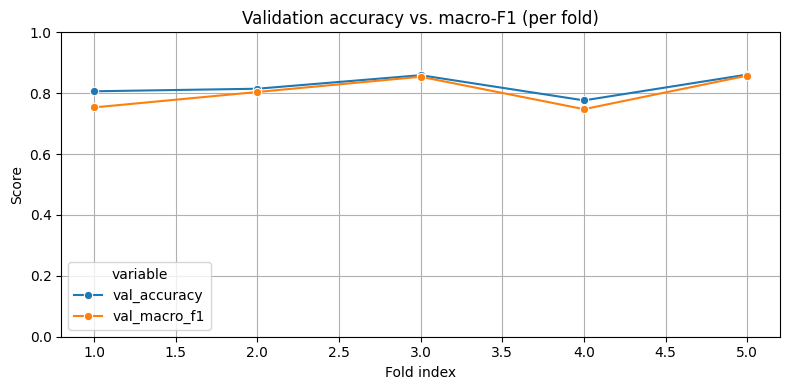

,fold_idx,val_accuracy,val_macro_f1,best_epoch
0,1,0.806306,0.753315,43
1,2,0.814737,0.803993,45
2,3,0.859184,0.854120,55
3,4,0.776398,0.747581,59
4,5,0.861298,0.857851,60


: 

In [ ]:
# Analyze cross-validation metrics
results_dir = results['results_folder']
cv_summary_path = results_dir + '/cv_summary.json'
with open(cv_summary_path, 'r') as f:
    fold_metrics = json.load(f)

fold_df = summarize_fold_validation_metrics(fold_metrics)
display(fold_df)

### 3.2 Test Set Evaluation: Confusion Matrix

Visualize confusion matrix on the frozen test set (30% of subjects, never seen during training).

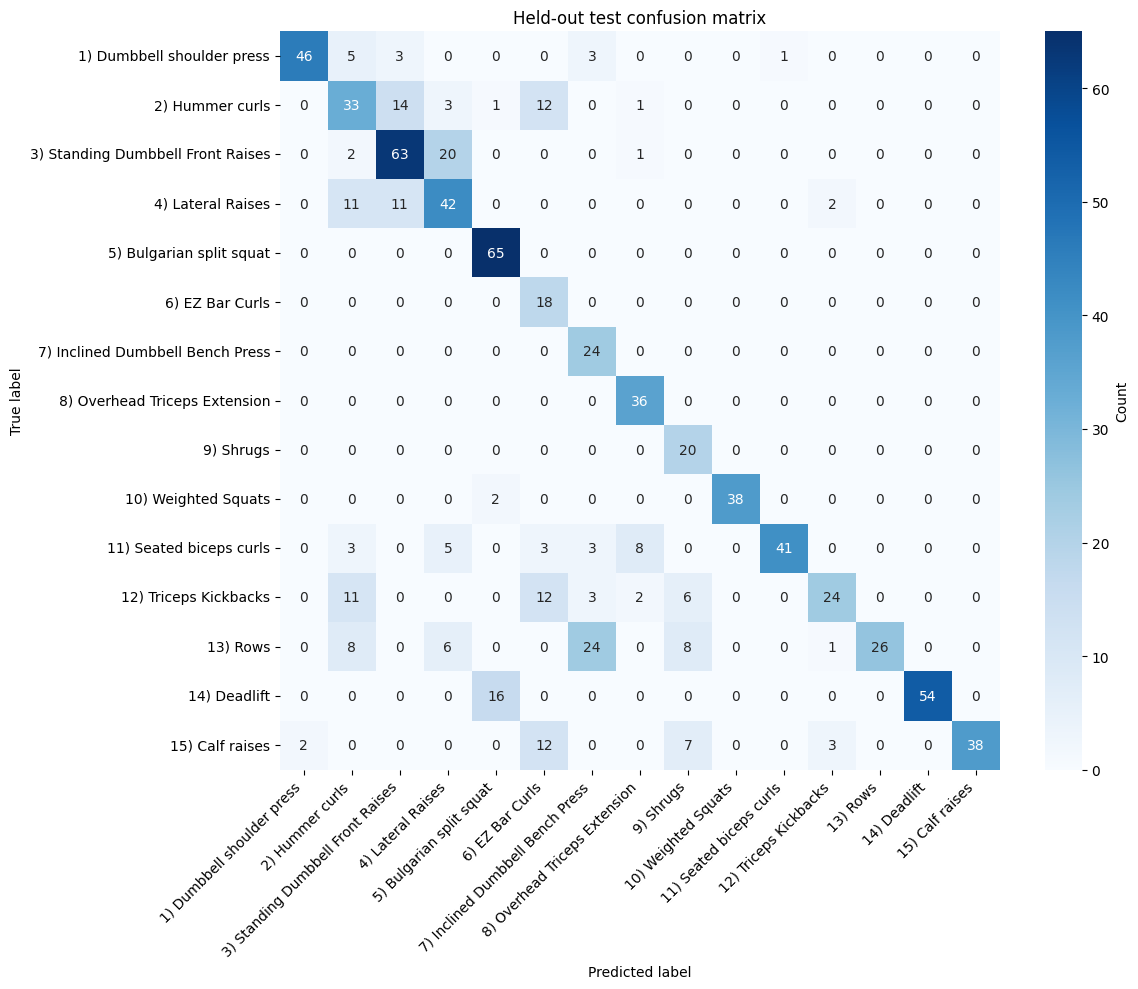

In [30]:
# Visualize confusion matrix on the frozen test set
final_metrics_path = "/mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/run_004/final_model/metrics.json"
with open(final_metrics_path, 'r') as f:
    final_metrics = json.load(f)

conf_matrix = np.array(final_metrics['confusion_matrix'])
ordered_labels = sort_labels_by_numeric_prefix(label_names)

plot_confusion_matrix_from_metrics(
    conf_matrix,
    current_class_order=label_names,
    desired_class_order=ordered_labels,
    normalize=False,
    title='Held-out test confusion matrix'
)


### 3.3 Per-Class F1 Scores

Identify which exercises are easiest/hardest to classify based on per-class F1 scores.

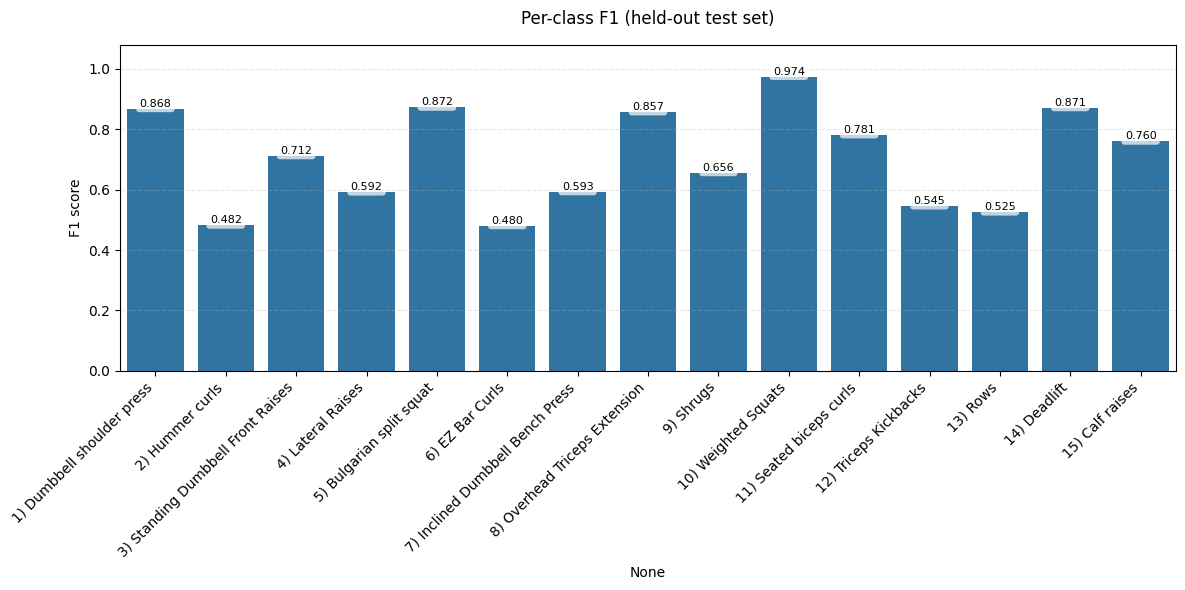

1) Dumbbell shoulder press           0.867925
2) Hummer curls                      0.481752
3) Standing Dumbbell Front Raises    0.711864
4) Lateral Raises                    0.591549
5) Bulgarian split squat             0.872483
6) EZ Bar Curls                      0.480000
7) Inclined Dumbbell Bench Press     0.592593
8) Overhead Triceps Extension        0.857143
9) Shrugs                            0.655738
10) Weighted Squats                  0.974359
11) Seated biceps curls              0.780952
12) Triceps Kickbacks                0.545455
13) Rows                             0.525253
14) Deadlift                         0.870968
15) Calf raises                      0.760000
dtype: float64

Macro F1: 0.7045
Test accuracy: 0.7073


In [31]:
# Plot per-class F1 scores
ordered_labels = sort_labels_by_numeric_prefix(label_names)
per_class_f1_series = plot_per_class_f1_scores(
    final_metrics['per_class_f1'],
    idx_to_label,
    desired_class_order=ordered_labels,
)

display(per_class_f1_series)
print(f"Macro F1: {final_metrics['test_macro_f1']:.4f}")
print(f"Test accuracy: {final_metrics['test_accuracy']:.4f}")


## 4. Multi-Run Statistical Evaluation (30 Independent Runs)

Train the same architecture 30 times with different random seeds to assess statistical robustness and sensitivity to train/test splits.

**Key Differences from K-Fold CV**:
- **30 independent 3-way splits** (train/val/test) instead of 5 folds from same pool
- **Different test subjects each run** (vs single frozen test set in CV)
- **No cross-validation per run** 
- **Output**: Mean ± std across 30 test sets for statistical significance


### 4.1 Enable Multi-Run Mode

Modify configuration to enable 30-run mode with different seeds (43-72).

In [8]:
# Enable multi_run mode in config
CONFIG_PATH = PROJECT_ROOT / 'config' / 'experiment_5.yaml'
with open(CONFIG_PATH, 'r') as f:
    experiment_config = yaml.safe_load(f)

# Enable multi-run mode
experiment_config['multi_run']['enabled'] = True

# Save updated config temporarily (or modify yaml directly)
temp_config_path = PROJECT_ROOT / 'config' / 'experiment_5_multirun.yaml'
with open(temp_config_path, 'w') as f:
    yaml.dump(experiment_config, f, default_flow_style=False)

print(f"✅ Multi-run mode enabled")
print(f"   Number of runs: {experiment_config['multi_run']['num_runs']}")
print(f"   Base seed: {experiment_config['multi_run']['base_seed']}")
print(f"   Seeds: {experiment_config['multi_run']['base_seed'] + 1} to {experiment_config['multi_run']['base_seed'] + experiment_config['multi_run']['num_runs']}")

Multi-run enabled with 30 runs
Base seed: 42


### 4.2 Execute Multi-Run Experiment

Run 30 independent training sessions with different train/val/test splits. **Skip this cell if loading saved results.**

In [9]:
# Run 30-run multi-seed experiment
multi_run_results, aggregated_stats = train_experiment_5_multi_run(
    dataset, 
    config_path=str(temp_config_path)
)

print("\n" + "="*60)
print("MULTI-RUN EXPERIMENT COMPLETED")
print("="*60)
print(f"Total runs: {len(multi_run_results)}")
print(f"Mean test accuracy: {aggregated_stats['test_accuracy']['mean']:.4f} ± {aggregated_stats['test_accuracy']['std']:.4f}")
print(f"Mean test macro F1: {aggregated_stats['test_macro_f1']['mean']:.4f} ± {aggregated_stats['test_macro_f1']['std']:.4f}")

INFO - Configuration loaded from /mnt/d/Graduation_Project/ai-virtual-coach/config/experiment_5_multirun.yaml
INFO - ============================================================
INFO - Starting Experiment 5 Multi-Run (30 seeds)
INFO - Multi-run folder: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/multi_run/multi_run_002
INFO - ============================================================
INFO - Created label mapping for 15 classes
INFO - 
INFO - Run 1/30 (seed=43)
INFO - ============================================================
INFO - Global random seed set to: 43
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1791 train, 512 val, 839 test samples
INFO - Split sizes: train=1791, val=512, test=839
I0000 00:00:1765510561.047882   60154 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5518 MB memory:  -> device: 0, name: NVIDIA GeForc

Epoch 1/60


2025-12-12 05:36:13.349371: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng57{k2=1,k13=0,k14=3,k18=1,k23=0} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0}, f32[32,64,112,112]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-12-12 05:36:13.365375: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.858296679s
Trying algorithm eng57{k2=1,k13=0,k14=3,k18=1,k23=0} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0}, f32[32,64,112,112]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

      3/Unknown 12s 47ms/step - accuracy: 0.0712 - loss: 3.3649   

I0000 00:00:1765510575.603871   60489 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - accuracy: 0.3506 - loss: 2.0933 - val_accuracy: 0.0703 - val_loss: 3.8251
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.5863 - loss: 1.4238 - val_accuracy: 0.0703 - val_loss: 5.6955
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6862 - loss: 1.1562 - val_accuracy: 0.0508 - val_loss: 7.2461
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.7504 - loss: 0.9850 - val_accuracy: 0.0508 - val_loss: 8.4635
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.8090 - loss: 0.8893 - val_accuracy: 0.0508 - val_loss: 9.1527
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8520 - loss: 0.7936 - val_accuracy: 0.0508 - val_loss: 8.2981
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8738 - loss: 0.7276 - val_accuracy: 0.1348 - val_loss: 7.0507
Epoch 8/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9101 - loss: 0.6650 - val_accuracy: 0.1289 - val_loss:

INFO - Run 1 completed: test_acc=0.7962, test_f1=0.8025
INFO - 
INFO - Run 2/30 (seed=44)
INFO - ============================================================
INFO - Global random seed set to: 44
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1703 train, 661 val, 778 test samples
INFO - Split sizes: train=1703, val=661, test=778
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - accuracy: 0.3212 - loss: 2.2228 - val_accuracy: 0.0726 - val_loss: 3.0970
Epoch 2/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.5220 - loss: 1.5487 - val_accuracy: 0.1059 - val_loss: 3.3438
Epoch 3/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.6254 - loss: 1.3172 - val_accuracy: 0.1089 - val_loss: 4.4012
Epoch 4/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.6747 - loss: 1.1916 - val_accuracy: 0.1513 - val_loss: 4.6249
Epoch 5/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.7375 - loss: 1.0612 - val_accuracy: 0.0499 - val_loss: 5.6127
Epoch 6/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.7604 - loss: 0.9784 - val_accuracy: 0.0439 - val_loss: 6.7160
Epoch 7/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.8180 - loss: 0.8553 - val_accuracy: 0.0711 - val_loss: 7.2024
Epoch 8/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.8362 - loss: 0.8155 - val_accuracy: 0.042

INFO - Run 2 completed: test_acc=0.7635, test_f1=0.7621
INFO - 
INFO - Run 3/30 (seed=45)
INFO - ============================================================
INFO - Global random seed set to: 45
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1831 train, 399 val, 912 test samples
INFO - Split sizes: train=1831, val=399, test=912
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.3528 - loss: 2.1061 - val_accuracy: 0.0551 - val_loss: 3.7040
Epoch 2/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.5778 - loss: 1.4232 - val_accuracy: 0.0251 - val_loss: 5.6354
Epoch 3/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.6718 - loss: 1.2015 - val_accuracy: 0.0251 - val_loss: 8.6333
Epoch 4/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.7253 - loss: 1.0570 - val_accuracy: 0.0251 - val_loss: 9.2196
Epoch 5/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8094 - loss: 0.8873 - val_accuracy: 0.0251 - val_loss: 7.6633
Epoch 6/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8263 - loss: 0.8257 - val_accuracy: 0.0376 - val_loss: 7.2700
Epoch 7/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8542 - loss: 0.7637 - val_accuracy: 0.0877 - val_loss: 6.9600
Epoch 8/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8766 - loss: 0.7186 - val_accuracy: 0.1228

INFO - Run 3 completed: test_acc=0.7478, test_f1=0.7448
INFO - 
INFO - Run 4/30 (seed=46)
INFO - ============================================================
INFO - Global random seed set to: 46
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1634 train, 606 val, 902 test samples
INFO - Split sizes: train=1634, val=606, test=902
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.3048 - loss: 2.2373 - val_accuracy: 0.0759 - val_loss: 3.4285
Epoch 2/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.4602 - loss: 1.6633 - val_accuracy: 0.0759 - val_loss: 5.8341
Epoch 3/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.5942 - loss: 1.3691 - val_accuracy: 0.0759 - val_loss: 6.8880
Epoch 4/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.6879 - loss: 1.1472 - val_accuracy: 0.0759 - val_loss: 7.8534
Epoch 5/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.7075 - loss: 1.0911 - val_accuracy: 0.0759 - val_loss: 9.1068
Epoch 6/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.7558 - loss: 0.9985 - val_accuracy: 0.0759 - val_loss: 7.9461
Epoch 7/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.8109 - loss: 0.9062 - val_accuracy: 0.0759 - val_loss: 6.7108
Epoch 8/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8097 - loss: 0.8621 - val_accuracy: 0.0776 

INFO - Run 4 completed: test_acc=0.7749, test_f1=0.7651
INFO - 
INFO - Run 5/30 (seed=47)
INFO - ============================================================
INFO - Global random seed set to: 47
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1691 train, 406 val, 1045 test samples
INFO - Split sizes: train=1691, val=406, test=1045
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 261ms/step - accuracy: 0.2986 - loss: 2.2507 - val_accuracy: 0.0493 - val_loss: 3.6103
Epoch 2/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.5269 - loss: 1.5724 - val_accuracy: 0.0493 - val_loss: 4.6415
Epoch 3/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.6168 - loss: 1.3316 - val_accuracy: 0.0591 - val_loss: 6.0181
Epoch 4/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.6777 - loss: 1.1656 - val_accuracy: 0.0591 - val_loss: 7.7933
Epoch 5/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.7398 - loss: 1.0245 - val_accuracy: 0.0591 - val_loss: 6.6079
Epoch 6/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.7830 - loss: 0.9308 - val_accuracy: 0.0591 - val_loss: 7.8926
Epoch 7/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8143 - loss: 0.8542 - val_accuracy: 0.0591 - val_loss: 6.2676
Epoch 8/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8445 - loss: 0.7970 - val_accuracy: 0.069

INFO - Run 5 completed: test_acc=0.8459, test_f1=0.8496
INFO - 
INFO - Run 6/30 (seed=48)
INFO - ============================================================
INFO - Global random seed set to: 48
INFO - Found 49 unique subject identities
WARNING - Val split missing classes: ['14) Deadlift']
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1853 train, 449 val, 840 test samples
INFO - Split sizes: train=1853, val=449, test=840
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.3432 - loss: 2.1180 - val_accuracy: 0.1158 - val_loss: 3.5663
Epoch 2/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5872 - loss: 1.4164 - val_accuracy: 0.0601 - val_loss: 5.0761
Epoch 3/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6859 - loss: 1.1692 - val_accuracy: 0.0000e+00 - val_loss: 6.7113
Epoch 4/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.7685 - loss: 0.9770 - val_accuracy: 0.0846 - val_loss: 7.3769
Epoch 5/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.8030 - loss: 0.8905 - val_accuracy: 0.0624 - val_loss: 8.0271
Epoch 6/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8505 - loss: 0.7884 - val_accuracy: 0.0690 - val_loss: 9.5177
Epoch 7/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8640 - loss: 0.7406 - val_accuracy: 0.1114 - val_loss: 9.8962
Epoch 8/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8931 - loss: 0.6840 - val_accuracy: 0.1

INFO - Run 6 completed: test_acc=0.7143, test_f1=0.7289
INFO - 
INFO - Run 7/30 (seed=49)
INFO - ============================================================
INFO - Global random seed set to: 49
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1853 train, 375 val, 914 test samples
INFO - Split sizes: train=1853, val=375, test=914
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.3233 - loss: 2.2162 - val_accuracy: 0.0533 - val_loss: 3.6576
Epoch 2/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.5391 - loss: 1.5430 - val_accuracy: 0.0533 - val_loss: 6.1717
Epoch 3/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.6330 - loss: 1.2856 - val_accuracy: 0.0533 - val_loss: 7.0046
Epoch 4/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.7242 - loss: 1.0797 - val_accuracy: 0.0533 - val_loss: 8.6591
Epoch 5/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7911 - loss: 0.9503 - val_accuracy: 0.0533 - val_loss: 7.2448
Epoch 6/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.8084 - loss: 0.8749 - val_accuracy: 0.0773 - val_loss: 7.7815
Epoch 7/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8386 - loss: 0.8146 - val_accuracy: 0.1707 - val_loss: 6.7599
Epoch 8/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8651 - loss: 0.7525 - val_accuracy: 0.104

INFO - Run 7 completed: test_acc=0.7921, test_f1=0.8036
INFO - 
INFO - Run 8/30 (seed=50)
INFO - ============================================================
INFO - Global random seed set to: 50
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1680 train, 520 val, 942 test samples
INFO - Split sizes: train=1680, val=520, test=942
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.3030 - loss: 2.2728 - val_accuracy: 0.0462 - val_loss: 3.3702
Epoch 2/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.4994 - loss: 1.6076 - val_accuracy: 0.0462 - val_loss: 5.4188
Epoch 3/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.6143 - loss: 1.3104 - val_accuracy: 0.0462 - val_loss: 6.3708
Epoch 4/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7036 - loss: 1.1237 - val_accuracy: 0.0462 - val_loss: 8.2724
Epoch 5/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7476 - loss: 0.9924 - val_accuracy: 0.0462 - val_loss: 8.3963
Epoch 6/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8030 - loss: 0.8881 - val_accuracy: 0.0462 - val_loss: 8.6066
Epoch 7/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8298 - loss: 0.8220 - val_accuracy: 0.0462 - val_loss: 7.1155
Epoch 8/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8524 - loss: 0.7772 - val_accuracy: 0.0865 

INFO - Run 8 completed: test_acc=0.7558, test_f1=0.7758
INFO - 
INFO - Run 9/30 (seed=51)
INFO - ============================================================
INFO - Global random seed set to: 51
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1786 train, 650 val, 706 test samples
INFO - Split sizes: train=1786, val=650, test=706
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.3421 - loss: 2.1338 - val_accuracy: 0.0708 - val_loss: 3.6129
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.5465 - loss: 1.5133 - val_accuracy: 0.0708 - val_loss: 4.6217
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.6674 - loss: 1.1941 - val_accuracy: 0.0708 - val_loss: 5.4949
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.7436 - loss: 1.0232 - val_accuracy: 0.0708 - val_loss: 6.7639
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.7968 - loss: 0.9034 - val_accuracy: 0.0708 - val_loss: 7.3696
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8427 - loss: 0.8024 - val_accuracy: 0.0708 - val_loss: 6.9707
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8673 - loss: 0.7480 - val_accuracy: 0.1600 - val_loss: 5.3749
Epoch 8/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8897 - loss: 0.7116 - val_accuracy: 0.1431 

INFO - Run 9 completed: test_acc=0.6360, test_f1=0.6711
INFO - 
INFO - Run 10/30 (seed=52)
INFO - ============================================================
INFO - Global random seed set to: 52
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1710 train, 561 val, 871 test samples
INFO - Split sizes: train=1710, val=561, test=871
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.3298 - loss: 2.1525 - val_accuracy: 0.0642 - val_loss: 3.6723
Epoch 2/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.5667 - loss: 1.4902 - val_accuracy: 0.0499 - val_loss: 4.8082
Epoch 3/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.6591 - loss: 1.2211 - val_accuracy: 0.0463 - val_loss: 7.0669
Epoch 4/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7480 - loss: 1.0170 - val_accuracy: 0.0463 - val_loss: 6.6238
Epoch 5/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.7953 - loss: 0.9364 - val_accuracy: 0.0463 - val_loss: 7.1869
Epoch 6/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8304 - loss: 0.8271 - val_accuracy: 0.0463 - val_loss: 6.9275
Epoch 7/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8637 - loss: 0.7643 - val_accuracy: 0.0570 - val_loss: 6.6989
Epoch 8/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8906 - loss: 0.7070 - val_accuracy: 0.0980 

INFO - Run 10 completed: test_acc=0.8048, test_f1=0.8015
INFO - 
INFO - Run 11/30 (seed=53)
INFO - ============================================================
INFO - Global random seed set to: 53
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1842 train, 535 val, 765 test samples
INFO - Split sizes: train=1842, val=535, test=765
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
     57/Unknown 8s 76ms/step - accuracy: 0.2576 - loss: 2.4219

2025-12-12 06:32:29.587073: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng40{k2=11,k6=0,k12=15,k13=1,k14=0,k15=0,k17=16,k22=3} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,32,112,112]{3,2,1,0}, f32[18,64,112,112]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-12-12 06:32:29.587988: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.953240182s
Trying algorithm eng40{k2=11,k6=0,k12=15,k13=1,k14=0,k15=0,k17=16,k22=3} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,32,112,112]{3,2,1,0}, f32[18,64,112,112]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_la

58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.3800 - loss: 2.0402 - val_accuracy: 0.0860 - val_loss: 3.7709
Epoch 2/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5798 - loss: 1.4359 - val_accuracy: 0.0860 - val_loss: 5.9785
Epoch 3/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.6889 - loss: 1.1828 - val_accuracy: 0.0860 - val_loss: 9.1265
Epoch 4/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.7378 - loss: 1.0377 - val_accuracy: 0.0860 - val_loss: 8.0487
Epoch 5/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.7823 - loss: 0.9541 - val_accuracy: 0.0860 - val_loss: 9.1964
Epoch 6/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8214 - loss: 0.8621 - val_accuracy: 0.0860 - val_loss: 8.3880
Epoch 7/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/step - accuracy: 0.8415 - loss: 0.8098 - val_accuracy: 0.0860 - val_loss: 8.6513
Epoch 8/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8572 - loss: 0.7614 - val_accuracy: 0.1813 - val_loss

INFO - Run 11 completed: test_acc=0.7046, test_f1=0.7236
INFO - 
INFO - Run 12/30 (seed=54)
INFO - ============================================================
INFO - Global random seed set to: 54
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1791 train, 401 val, 950 test samples
INFO - Split sizes: train=1791, val=401, test=950
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.3317 - loss: 2.1852 - val_accuracy: 0.0549 - val_loss: 3.3643
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5589 - loss: 1.5258 - val_accuracy: 0.0249 - val_loss: 4.6979
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.6521 - loss: 1.2621 - val_accuracy: 0.0748 - val_loss: 4.6674
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.7365 - loss: 1.0428 - val_accuracy: 0.0748 - val_loss: 5.0685
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.7778 - loss: 0.9442 - val_accuracy: 0.0499 - val_loss: 8.0339
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8224 - loss: 0.8546 - val_accuracy: 0.1222 - val_loss: 7.6948
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8481 - loss: 0.7828 - val_accuracy: 0.0723 - val_loss: 11.2438
Epoch 8/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8660 - loss: 0.7460 - val_accuracy: 0.0723

INFO - Run 12 completed: test_acc=0.7789, test_f1=0.7879
INFO - 
INFO - Run 13/30 (seed=55)
INFO - ============================================================
INFO - Global random seed set to: 55
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1832 train, 380 val, 930 test samples
INFO - Split sizes: train=1832, val=380, test=930
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.3068 - loss: 2.2659 - val_accuracy: 0.0526 - val_loss: 3.6573
Epoch 2/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5464 - loss: 1.5160 - val_accuracy: 0.0526 - val_loss: 5.0620
Epoch 3/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.6501 - loss: 1.2464 - val_accuracy: 0.0526 - val_loss: 5.5860
Epoch 4/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.7233 - loss: 1.0659 - val_accuracy: 0.0526 - val_loss: 7.7644
Epoch 5/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.7615 - loss: 0.9889 - val_accuracy: 0.0526 - val_loss: 7.6036
Epoch 6/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8029 - loss: 0.8797 - val_accuracy: 0.0526 - val_loss: 7.7588
Epoch 7/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8428 - loss: 0.8033 - val_accuracy: 0.0658 - val_loss: 8.5425
Epoch 8/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8761 - loss: 0.7274 - val_accuracy: 0.0816 

INFO - Run 13 completed: test_acc=0.8043, test_f1=0.8070
INFO - 
INFO - Run 14/30 (seed=56)
INFO - ============================================================
INFO - Global random seed set to: 56
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1606 train, 588 val, 948 test samples
INFO - Split sizes: train=1606, val=588, test=948
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - accuracy: 0.3076 - loss: 2.2039 - val_accuracy: 0.0714 - val_loss: 3.3287
Epoch 2/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.5062 - loss: 1.6119 - val_accuracy: 0.0714 - val_loss: 5.0789
Epoch 3/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6202 - loss: 1.3173 - val_accuracy: 0.0782 - val_loss: 4.9848
Epoch 4/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.6924 - loss: 1.1332 - val_accuracy: 0.0782 - val_loss: 6.5868
Epoch 5/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.7298 - loss: 1.0348 - val_accuracy: 0.0782 - val_loss: 7.0608
Epoch 6/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.7790 - loss: 0.9367 - val_accuracy: 0.0782 - val_loss: 7.1050
Epoch 7/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7895 - loss: 0.9146 - val_accuracy: 0.0799 - val_loss: 7.4507
Epoch 8/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8263 - loss: 0.8300 - val_accuracy: 0.1003 

INFO - Run 14 completed: test_acc=0.7848, test_f1=0.7619
INFO - 
INFO - Run 15/30 (seed=57)
INFO - ============================================================
INFO - Global random seed set to: 57
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1709 train, 625 val, 808 test samples
INFO - Split sizes: train=1709, val=625, test=808
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.3288 - loss: 2.1827 - val_accuracy: 0.0736 - val_loss: 3.3892
Epoch 2/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5477 - loss: 1.5136 - val_accuracy: 0.0736 - val_loss: 5.8186
Epoch 3/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6870 - loss: 1.1695 - val_accuracy: 0.0736 - val_loss: 7.2165
Epoch 4/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.7291 - loss: 1.0439 - val_accuracy: 0.0736 - val_loss: 7.9038
Epoch 5/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.7923 - loss: 0.9147 - val_accuracy: 0.0736 - val_loss: 8.0405
Epoch 6/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8209 - loss: 0.8489 - val_accuracy: 0.0736 - val_loss: 7.5256
Epoch 7/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8607 - loss: 0.7590 - val_accuracy: 0.0736 - val_loss: 5.7006
Epoch 8/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8871 - loss: 0.7059 - val_accuracy: 0.1056 

INFO - Run 15 completed: test_acc=0.6881, test_f1=0.6932
INFO - 
INFO - Run 16/30 (seed=58)
INFO - ============================================================
INFO - Global random seed set to: 58
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1768 train, 545 val, 829 test samples
INFO - Split sizes: train=1768, val=545, test=829
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.3869 - loss: 1.9578 - val_accuracy: 0.0624 - val_loss: 2.9829
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6007 - loss: 1.3786 - val_accuracy: 0.0624 - val_loss: 4.3342
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6912 - loss: 1.1436 - val_accuracy: 0.0661 - val_loss: 5.0993
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.7681 - loss: 0.9877 - val_accuracy: 0.0624 - val_loss: 6.0896
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.7964 - loss: 0.9123 - val_accuracy: 0.0624 - val_loss: 8.0087
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8411 - loss: 0.8238 - val_accuracy: 0.0624 - val_loss: 7.2481
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8654 - loss: 0.7578 - val_accuracy: 0.0624 - val_loss: 8.1320
Epoch 8/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8840 - loss: 0.7078 - val_accuracy: 0.0624 

INFO - Run 16 completed: test_acc=0.6369, test_f1=0.6291
INFO - 
INFO - Run 17/30 (seed=59)
INFO - ============================================================
INFO - Global random seed set to: 59
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1653 train, 490 val, 999 test samples
INFO - Split sizes: train=1653, val=490, test=999
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - accuracy: 0.3061 - loss: 2.2371 - val_accuracy: 0.0224 - val_loss: 3.8124
Epoch 2/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5166 - loss: 1.5677 - val_accuracy: 0.0163 - val_loss: 5.4239
Epoch 3/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6334 - loss: 1.2978 - val_accuracy: 0.0163 - val_loss: 8.3268
Epoch 4/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.7151 - loss: 1.0746 - val_accuracy: 0.0163 - val_loss: 8.1148
Epoch 5/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7647 - loss: 0.9795 - val_accuracy: 0.0163 - val_loss: 10.1353
Epoch 6/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8125 - loss: 0.8722 - val_accuracy: 0.0163 - val_loss: 8.2851
Epoch 7/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8355 - loss: 0.8183 - val_accuracy: 0.0163 - val_loss: 9.1693
Epoch 8/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.8463 - loss: 0.7823 - val_accuracy: 0.016

IOStream.flush timed out


52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 467ms/step - accuracy: 0.9933 - loss: 0.4244 - val_accuracy: 0.8490 - val_loss: 0.7944
Epoch 60/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9946 - loss: 0.4178 - val_accuracy: 0.8469 - val_loss: 0.7932
Restoring model weights from the end of the best epoch: 46.


INFO - Run 17 completed: test_acc=0.7758, test_f1=0.7684
INFO - 
INFO - Run 18/30 (seed=60)
INFO - ============================================================
INFO - Global random seed set to: 60
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1841 train, 448 val, 853 test samples
INFO - Split sizes: train=1841, val=448, test=853
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.3466 - loss: 2.0739 - val_accuracy: 0.0223 - val_loss: 4.4581
Epoch 2/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6100 - loss: 1.3639 - val_accuracy: 0.0223 - val_loss: 8.6241
Epoch 3/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7159 - loss: 1.0921 - val_accuracy: 0.0223 - val_loss: 10.1676
Epoch 4/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.7789 - loss: 0.9579 - val_accuracy: 0.0223 - val_loss: 11.7088
Epoch 5/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8387 - loss: 0.8226 - val_accuracy: 0.0223 - val_loss: 9.5767
Epoch 6/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8506 - loss: 0.7885 - val_accuracy: 0.0223 - val_loss: 9.5793
Epoch 7/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8832 - loss: 0.7170 - val_accuracy: 0.0290 - val_loss: 7.5027
Epoch 8/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8995 - loss: 0.6818 - val_accuracy: 0.0625

INFO - Run 18 completed: test_acc=0.7620, test_f1=0.7722
INFO - 
INFO - Run 19/30 (seed=61)
INFO - ============================================================
INFO - Global random seed set to: 61
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1789 train, 416 val, 937 test samples
INFO - Split sizes: train=1789, val=416, test=937
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.3399 - loss: 2.1387 - val_accuracy: 0.0769 - val_loss: 3.5718
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.5545 - loss: 1.5326 - val_accuracy: 0.0769 - val_loss: 5.3911
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.6350 - loss: 1.2714 - val_accuracy: 0.0769 - val_loss: 6.6958
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7183 - loss: 1.0893 - val_accuracy: 0.0769 - val_loss: 8.0580
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7753 - loss: 0.9729 - val_accuracy: 0.0769 - val_loss: 8.5491
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8172 - loss: 0.8706 - val_accuracy: 0.0769 - val_loss: 6.3420
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8357 - loss: 0.8108 - val_accuracy: 0.0986 - val_loss: 6.1718
Epoch 8/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.8765 - loss: 0.7344 - val_accuracy: 0.0745

INFO - Run 19 completed: test_acc=0.7855, test_f1=0.8030
INFO - 
INFO - Run 20/30 (seed=62)
INFO - ============================================================
INFO - Global random seed set to: 62
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1775 train, 547 val, 820 test samples
INFO - Split sizes: train=1775, val=547, test=820
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - accuracy: 0.3285 - loss: 2.1644 - val_accuracy: 0.0841 - val_loss: 3.8568
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.5707 - loss: 1.4742 - val_accuracy: 0.0841 - val_loss: 4.6988
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.6766 - loss: 1.2016 - val_accuracy: 0.0841 - val_loss: 4.5128
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.7318 - loss: 1.0366 - val_accuracy: 0.0658 - val_loss: 4.2634
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8085 - loss: 0.8886 - val_accuracy: 0.0841 - val_loss: 5.5625
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8383 - loss: 0.8167 - val_accuracy: 0.0530 - val_loss: 5.8399
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.8817 - loss: 0.7275 - val_accuracy: 0.0402 - val_loss: 6.4592
Epoch 8/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.8963 - loss: 0.6754 - val_accuracy: 0.0512 -

IOStream.flush timed out


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 448ms/step - accuracy: 0.9972 - loss: 0.4015 - val_accuracy: 0.7934 - val_loss: 0.8412
Restoring model weights from the end of the best epoch: 43.


INFO - Run 20 completed: test_acc=0.7634, test_f1=0.7658
INFO - 
INFO - Run 21/30 (seed=63)
INFO - ============================================================
INFO - Global random seed set to: 63
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1523 train, 525 val, 1094 test samples
INFO - Split sizes: train=1523, val=525, test=1094
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 248ms/step - accuracy: 0.3322 - loss: 2.1705 - val_accuracy: 0.0381 - val_loss: 3.7448
Epoch 2/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.5391 - loss: 1.5706 - val_accuracy: 0.0381 - val_loss: 5.2716
Epoch 3/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.6724 - loss: 1.2222 - val_accuracy: 0.0381 - val_loss: 6.9618
Epoch 4/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.7374 - loss: 1.0299 - val_accuracy: 0.0381 - val_loss: 9.8022
Epoch 5/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7886 - loss: 0.9247 - val_accuracy: 0.0381 - val_loss: 9.2962
Epoch 6/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 309ms/step - accuracy: 0.8214 - loss: 0.8304 - val_accuracy: 0.0381 - val_loss: 8.7619
Epoch 7/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8707 - loss: 0.7441 - val_accuracy: 0.0381 - val_loss: 8.2638
Epoch 8/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 521ms/step - accuracy: 0.8726 - loss: 0.7231 - val_accuracy: 0.04

INFO - Run 21 completed: test_acc=0.8190, test_f1=0.8059
INFO - 
INFO - Run 22/30 (seed=64)
INFO - ============================================================
INFO - Global random seed set to: 64
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1822 train, 467 val, 853 test samples
INFO - Split sizes: train=1822, val=467, test=853
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.3738 - loss: 2.0569 - val_accuracy: 0.0600 - val_loss: 4.0571
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5692 - loss: 1.4717 - val_accuracy: 0.0600 - val_loss: 5.2655
Epoch 3/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6745 - loss: 1.1997 - val_accuracy: 0.0600 - val_loss: 8.5630
Epoch 4/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7437 - loss: 1.0569 - val_accuracy: 0.0600 - val_loss: 6.3816
Epoch 5/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7914 - loss: 0.9190 - val_accuracy: 0.0600 - val_loss: 7.3177
Epoch 6/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.8216 - loss: 0.8558 - val_accuracy: 0.0707 - val_loss: 6.2628
Epoch 7/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.8524 - loss: 0.7623 - val_accuracy: 0.0771 - val_loss: 7.9426
Epoch 8/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8716 - loss: 0.7298 - val_accuracy: 0.0792 -

INFO - Run 22 completed: test_acc=0.7761, test_f1=0.7901
INFO - 
INFO - Run 23/30 (seed=65)
INFO - ============================================================
INFO - Global random seed set to: 65
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1779 train, 515 val, 848 test samples
INFO - Split sizes: train=1779, val=515, test=848
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.3598 - loss: 2.0845 - val_accuracy: 0.0835 - val_loss: 3.1880
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.5823 - loss: 1.4573 - val_accuracy: 0.0893 - val_loss: 4.6373
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6841 - loss: 1.1514 - val_accuracy: 0.0893 - val_loss: 6.2241
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.7470 - loss: 1.0237 - val_accuracy: 0.0893 - val_loss: 7.8390
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7937 - loss: 0.8969 - val_accuracy: 0.0893 - val_loss: 5.5831
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8409 - loss: 0.8010 - val_accuracy: 0.1670 - val_loss: 4.9429
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8752 - loss: 0.7367 - val_accuracy: 0.1223 - val_loss: 7.1386
Epoch 8/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8921 - loss: 0.6987 - val_accuracy: 0.1340 -

INFO - Run 23 completed: test_acc=0.6250, test_f1=0.6294
INFO - 
INFO - Run 24/30 (seed=66)
INFO - ============================================================
INFO - Global random seed set to: 66
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1799 train, 522 val, 821 test samples
INFO - Split sizes: train=1799, val=522, test=821
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.3396 - loss: 2.1410 - val_accuracy: 0.0345 - val_loss: 3.6536
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5481 - loss: 1.5098 - val_accuracy: 0.0383 - val_loss: 5.0917
Epoch 3/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6581 - loss: 1.2341 - val_accuracy: 0.0383 - val_loss: 4.8385
Epoch 4/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7143 - loss: 1.0847 - val_accuracy: 0.0383 - val_loss: 6.1472
Epoch 5/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 0.7715 - loss: 0.9443 - val_accuracy: 0.0383 - val_loss: 7.0279
Epoch 6/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8327 - loss: 0.8368 - val_accuracy: 0.0383 - val_loss: 5.4256
Epoch 7/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8344 - loss: 0.8222 - val_accuracy: 0.0479 - val_loss: 4.8951
Epoch 8/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8577 - loss: 0.7608 - val_accuracy: 0.0862

INFO - Run 24 completed: test_acc=0.6882, test_f1=0.6961
INFO - 
INFO - Run 25/30 (seed=67)
INFO - ============================================================
INFO - Global random seed set to: 67
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1739 train, 627 val, 776 test samples
INFO - Split sizes: train=1739, val=627, test=776
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.3249 - loss: 2.1877 - val_accuracy: 0.0957 - val_loss: 3.7902
Epoch 2/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.5486 - loss: 1.5434 - val_accuracy: 0.0734 - val_loss: 4.4548
Epoch 3/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6647 - loss: 1.2431 - val_accuracy: 0.0734 - val_loss: 7.0538
Epoch 4/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.7435 - loss: 1.0478 - val_accuracy: 0.0734 - val_loss: 8.7332
Epoch 5/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7809 - loss: 0.9526 - val_accuracy: 0.0734 - val_loss: 7.3274
Epoch 6/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8281 - loss: 0.8303 - val_accuracy: 0.0734 - val_loss: 7.3482
Epoch 7/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8447 - loss: 0.7899 - val_accuracy: 0.1021 - val_loss: 8.0137
Epoch 8/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8861 - loss: 0.7061 - val_accuracy: 0.0494 -

INFO - Run 25 completed: test_acc=0.7732, test_f1=0.7790
INFO - 
INFO - Run 26/30 (seed=68)
INFO - ============================================================
INFO - Global random seed set to: 68
INFO - Found 49 unique subject identities
INFO - Subject split: 25 train, 10 val, 14 test subjects
INFO - Sample split: 1762 train, 644 val, 736 test samples
INFO - Split sizes: train=1762, val=644, test=736
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.3048 - loss: 2.2040 - val_accuracy: 0.1009 - val_loss: 3.5165
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5409 - loss: 1.5381 - val_accuracy: 0.0528 - val_loss: 4.7768
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.6623 - loss: 1.2309 - val_accuracy: 0.0528 - val_loss: 7.3256
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7594 - loss: 1.0105 - val_accuracy: 0.0528 - val_loss: 7.4305
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.7662 - loss: 0.9746 - val_accuracy: 0.0528 - val_loss: 7.7796
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8201 - loss: 0.8507 - val_accuracy: 0.0745 - val_loss: 8.3291
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8428 - loss: 0.8143 - val_accuracy: 0.1211 - val_loss: 9.0990
Epoch 8/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8632 - loss: 0.7572 - val_accuracy: 0.0854 -

: 

### 4.3 Resume Crashed Multi-Run (Optional)

Use this cell **ONLY** if the previous run crashed/interrupted. It loads completed runs and continues from where it stopped.

In [10]:
# RESUME crashed multi-run experiment (skip for fresh runs)
# Update the path below to your actual multi_run folder
RESUME_FOLDER = PROJECT_ROOT / "experiments/exer_recog/results/exp_05_small_cnn/multi_run/multi_run_001"

print(f"Attempting to resume from: {RESUME_FOLDER}")
print("="*60)

multi_run_results, aggregated_stats = train_experiment_5_multi_run(
    dataset, 
    config_path=str(temp_config_path),
    resume_folder=str(RESUME_FOLDER)
)

print("\n" + "="*60)
print("MULTI-RUN EXPERIMENT COMPLETED (RESUMED)")
print("="*60)

INFO - Configuration loaded from /mnt/d/Graduation_Project/ai-virtual-coach/config/experiment_5_multirun.yaml
INFO - ============================================================
INFO - RESUMING Experiment 5 Multi-Run from: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/multi_run/multi_run_001
INFO - ============================================================
INFO - Created label mapping for 15 classes
INFO - Loaded existing run 1: test_acc=0.7962, test_f1=0.8025
INFO - Loaded existing run 2: test_acc=0.7635, test_f1=0.7621
INFO - Loaded existing run 3: test_acc=0.7478, test_f1=0.7448
INFO - Loaded existing run 4: test_acc=0.7749, test_f1=0.7651
INFO - Loaded existing run 5: test_acc=0.8459, test_f1=0.8496
INFO - Loaded existing run 6: test_acc=0.7143, test_f1=0.7289
INFO - Loaded existing run 7: test_acc=0.7921, test_f1=0.8036
INFO - Loaded existing run 8: test_acc=0.7558, test_f1=0.7758
INFO - Loaded existing run 9: test_acc=0.6360, test_f1

Attempting to resume from: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/multi_run/multi_run_001


INFO - Loaded existing run 21: test_acc=0.8190, test_f1=0.8059
INFO - Loaded existing run 22: test_acc=0.7761, test_f1=0.7901
INFO - Loaded existing run 23: test_acc=0.6250, test_f1=0.6294
INFO - Loaded existing run 24: test_acc=0.6882, test_f1=0.6961
INFO - Loaded existing run 25: test_acc=0.7732, test_f1=0.7790
INFO - Loaded existing run 26: test_acc=0.7327, test_f1=0.7347
INFO - ============================================================
INFO - Found 26 completed runs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
INFO - Remaining runs: 4
INFO - ============================================================
INFO - 
INFO - Run 27/30 (seed=69)
INFO - ============================================================
INFO - Global random seed set to: 69
INFO - Found 49 unique subject identities
WARNING - Val split missing classes: ['4) Lateral Raises']
INFO - Subject split: 27 train, 9 val, 13 test subjects
INFO - Sample split: 1944 train, 290

Epoch 1/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - accuracy: 0.3256 - loss: 2.1418 - val_accuracy: 0.0690 - val_loss: 3.7324
Epoch 2/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.5484 - loss: 1.5193 - val_accuracy: 0.0690 - val_loss: 5.4758
Epoch 3/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.6291 - loss: 1.2712 - val_accuracy: 0.0828 - val_loss: 5.4407
Epoch 4/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.7253 - loss: 1.0716 - val_accuracy: 0.0793 - val_loss: 6.8985
Epoch 5/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7840 - loss: 0.9194 - val_accuracy: 0.0828 - val_loss: 7.2779
Epoch 6/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8143 - loss: 0.8649 - val_accuracy: 0.0828 - val_loss: 6.5204
Epoch 7/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.8416 - loss: 0.7910 - val_accuracy: 0.0828 - val_loss: 6.5709
Epoch 8/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.8796 - loss: 0.7261 - val_accuracy: 0.1345 

INFO - Run 27 completed: test_acc=0.8326, test_f1=0.8350
INFO - Multi-run summary saved to /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/multi_run/multi_run_001
INFO - Progress saved (27/30 runs complete)
INFO - 
INFO - Run 28/30 (seed=70)
INFO - ============================================================
INFO - Global random seed set to: 70
INFO - Found 49 unique subject identities
INFO - Subject split: 27 train, 9 val, 13 test subjects
INFO - Sample split: 1881 train, 320 val, 941 test samples
INFO - Split sizes: train=1881, val=320, test=941
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
     58/Unknown 11s 81ms/step - accuracy: 0.2569 - loss: 2.4955

2025-12-12 19:15:09.625130: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng57{k2=5,k13=1,k14=2,k18=1,k23=0} for conv (f32[32,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,1,224,224]{3,2,1,0}, f32[25,32,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-12-12 19:15:09.670466: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.163459417s
Trying algorithm eng57{k2=5,k13=1,k14=2,k18=1,k23=0} for conv (f32[32,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,1,224,224]{3,2,1,0}, f32[25,32,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__

59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - accuracy: 0.3557 - loss: 2.1200 - val_accuracy: 0.0750 - val_loss: 3.2401
Epoch 2/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5630 - loss: 1.4695 - val_accuracy: 0.1125 - val_loss: 3.9548
Epoch 3/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6688 - loss: 1.2006 - val_accuracy: 0.0750 - val_loss: 4.4174
Epoch 4/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 255ms/step - accuracy: 0.7416 - loss: 1.0514 - val_accuracy: 0.0750 - val_loss: 6.3787
Epoch 5/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.7900 - loss: 0.9208 - val_accuracy: 0.0750 - val_loss: 6.1423
Epoch 6/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 438ms/step - accuracy: 0.8214 - loss: 0.8452 - val_accuracy: 0.1000 - val_loss: 5.6651
Epoch 7/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.8538 - loss: 0.7696 - val_accuracy: 0.1094 - val_loss: 5.7101
Epoch 8/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8873 - loss: 0.6989 - val_accuracy: 0.0469 - val_

INFO - Run 28 completed: test_acc=0.7790, test_f1=0.7621
INFO - Multi-run summary saved to /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/multi_run/multi_run_001
INFO - Progress saved (28/30 runs complete)
INFO - 
INFO - Run 29/30 (seed=71)
INFO - ============================================================
INFO - Global random seed set to: 71
INFO - Found 49 unique subject identities
INFO - Subject split: 27 train, 9 val, 13 test subjects
INFO - Sample split: 1974 train, 477 val, 691 test samples
INFO - Split sizes: train=1974, val=477, test=691
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - accuracy: 0.3556 - loss: 2.1048 - val_accuracy: 0.1195 - val_loss: 3.4720
Epoch 2/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.5689 - loss: 1.4502 - val_accuracy: 0.0964 - val_loss: 4.9972
Epoch 3/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.6697 - loss: 1.1763 - val_accuracy: 0.0964 - val_loss: 5.4506
Epoch 4/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.7437 - loss: 1.0188 - val_accuracy: 0.0964 - val_loss: 6.1438
Epoch 5/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7852 - loss: 0.9247 - val_accuracy: 0.1174 - val_loss: 5.5638
Epoch 6/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8384 - loss: 0.8134 - val_accuracy: 0.0860 - val_loss: 6.5609
Epoch 7/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.8678 - loss: 0.7364 - val_accuracy: 0.0608 - val_loss: 9.3674
Epoch 8/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.8592 - loss: 0.7438 - val_accuracy: 0.054

INFO - Run 29 completed: test_acc=0.7598, test_f1=0.7537
INFO - Multi-run summary saved to /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/multi_run/multi_run_001
INFO - Progress saved (29/30 runs complete)
INFO - 
INFO - Run 30/30 (seed=72)
INFO - ============================================================
INFO - Global random seed set to: 72
INFO - Found 49 unique subject identities
INFO - Subject split: 27 train, 9 val, 13 test subjects
INFO - Sample split: 1970 train, 473 val, 699 test samples
INFO - Split sizes: train=1970, val=473, test=699
INFO - Creating augmenter: {'horizontal_flip': True, 'random_erasing': {'aspect_ratio': 0.3, 'enabled': False, 'max_area': 0.15, 'min_area': 0.02, 'probability': 0.2}, 'rotation_degrees': 5, 'translation_height': 0.1, 'translation_width': 0.1, 'zoom_max': 1.05, 'zoom_min': 0.9}
INFO - Built small GEI CNN with 129,199 parameters


Epoch 1/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - accuracy: 0.3929 - loss: 2.0442 - val_accuracy: 0.0973 - val_loss: 3.4694
Epoch 2/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.5853 - loss: 1.4018 - val_accuracy: 0.0973 - val_loss: 4.7719
Epoch 3/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.6944 - loss: 1.1652 - val_accuracy: 0.0973 - val_loss: 6.8424
Epoch 4/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.7690 - loss: 0.9561 - val_accuracy: 0.0973 - val_loss: 7.6367
Epoch 5/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8198 - loss: 0.8426 - val_accuracy: 0.0973 - val_loss: 8.3298
Epoch 6/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8401 - loss: 0.7830 - val_accuracy: 0.0973 - val_loss: 6.5325
Epoch 7/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.8904 - loss: 0.7121 - val_accuracy: 0.1691 - val_loss: 5.7519
Epoch 8/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.8970 - loss: 0.6708 - val_accuracy: 0.1543

INFO - Run 30 completed: test_acc=0.7325, test_f1=0.7456
INFO - Multi-run summary saved to /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/multi_run/multi_run_001
INFO - Progress saved (30/30 runs complete)
INFO - Multi-run summary saved to /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/multi_run/multi_run_001
INFO - 
INFO - MULTI-RUN COMPLETE
INFO - ============================================================
INFO - Test Accuracy:  0.7545 ± 0.0549
INFO - Test Macro F1:  0.7583 ± 0.0522
INFO - Results saved to: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/multi_run/multi_run_001
INFO - ============================================================



MULTI-RUN EXPERIMENT COMPLETED (RESUMED)


### 4.4 Aggregated Statistics Summary

Display statistical summary of test metrics across all 30 runs.

In [11]:
# Display aggregated statistics
runs_df = display_multi_run_summary(multi_run_results, aggregated_stats)
display(runs_df)

AGGREGATED STATISTICS (30 runs)

Test Accuracy:  0.7545 ± 0.0549
  Min: 0.6250
  Max: 0.8459

Test Macro F1:  0.7583 ± 0.0522
  Min: 0.6291
  Max: 0.8496


All Runs (sorted by test accuracy):
    run_idx  seed  test_accuracy  test_macro_f1  val_accuracy
0         5    47       0.845933       0.849561      0.751232
1        27    69       0.832599       0.834989      0.837931
2        21    63       0.819013       0.805870      0.815238
3        10    52       0.804822       0.801531      0.882353
4        13    55       0.804301       0.806962      0.792105
5         1    43       0.796186       0.802524      0.847656
6         7    49       0.792123       0.803610      0.773333
7        19    61       0.785486       0.802954      0.836538
8        14    56       0.784810       0.761900      0.845238
9        28    70       0.778959       0.762064      0.790625
10       12    54       0.778947       0.787856      0.753117
11       22    64       0.776084       0.790056      0.845824
12

,run_idx,seed,test_accuracy,test_macro_f1,val_accuracy
0,5,47,0.845933,0.849561,0.751232
1,27,69,0.832599,0.834989,0.837931
2,21,63,0.819013,0.805870,0.815238
3,10,52,0.804822,0.801531,0.882353
4,13,55,0.804301,0.806962,0.792105
5,1,43,0.796186,0.802524,0.847656
6,7,49,0.792123,0.803610,0.773333
7,19,61,0.785486,0.802954,0.836538
8,14,56,0.784810,0.761900,0.845238
9,28,70,0.778959,0.762064,0.790625


### 4.5 Performance Distribution Plots

Visualize distribution of test accuracy and F1 scores using box plots and histograms.

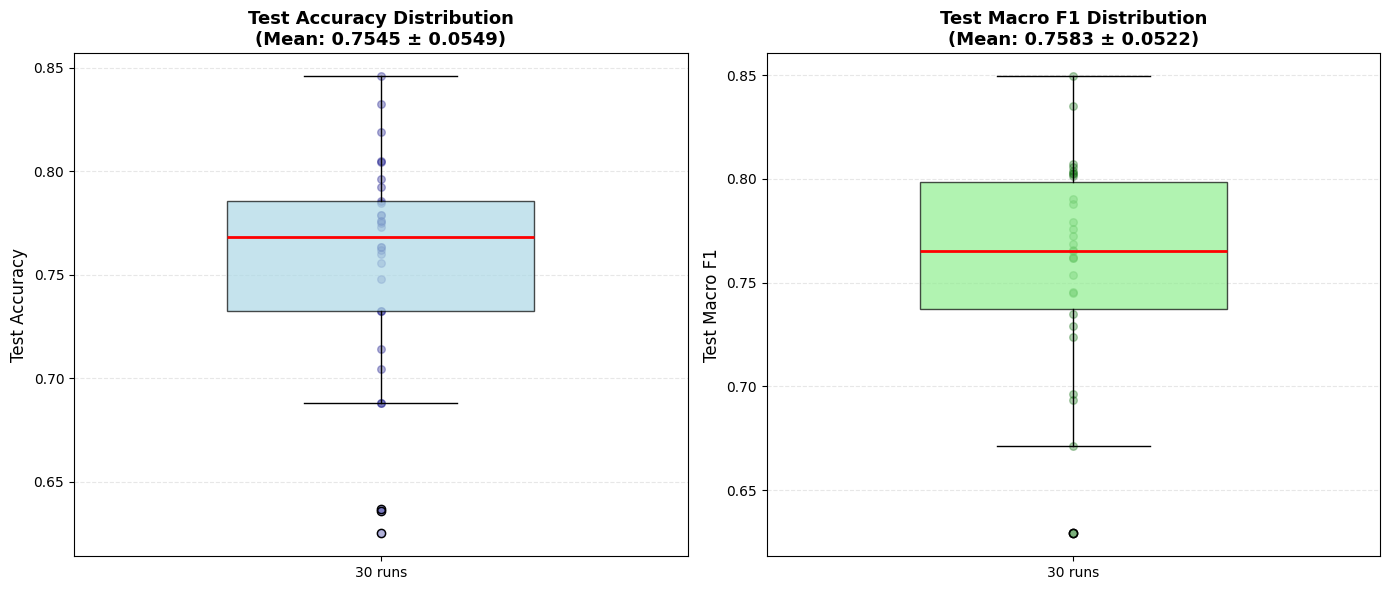

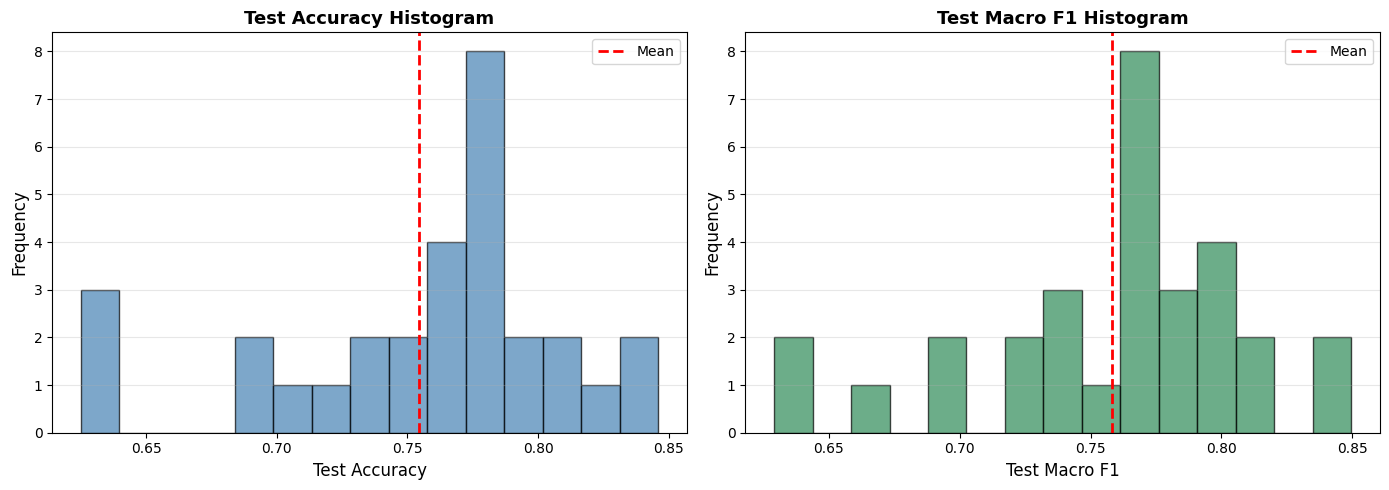

In [12]:
# Plot distributions of test accuracy and F1 across multiple runs
plot_multi_run_distributions(multi_run_results, aggregated_stats)

### 4.6 Best vs Worst Run Comparison

Compare confusion matrices and per-class F1 scores between the best and worst performing runs to identify what causes poor performance.

Best Run:  #5 (seed=47) - Acc: 0.8459, F1: 0.8496
Worst Run: #23 (seed=65) - Acc: 0.6250, F1: 0.6294


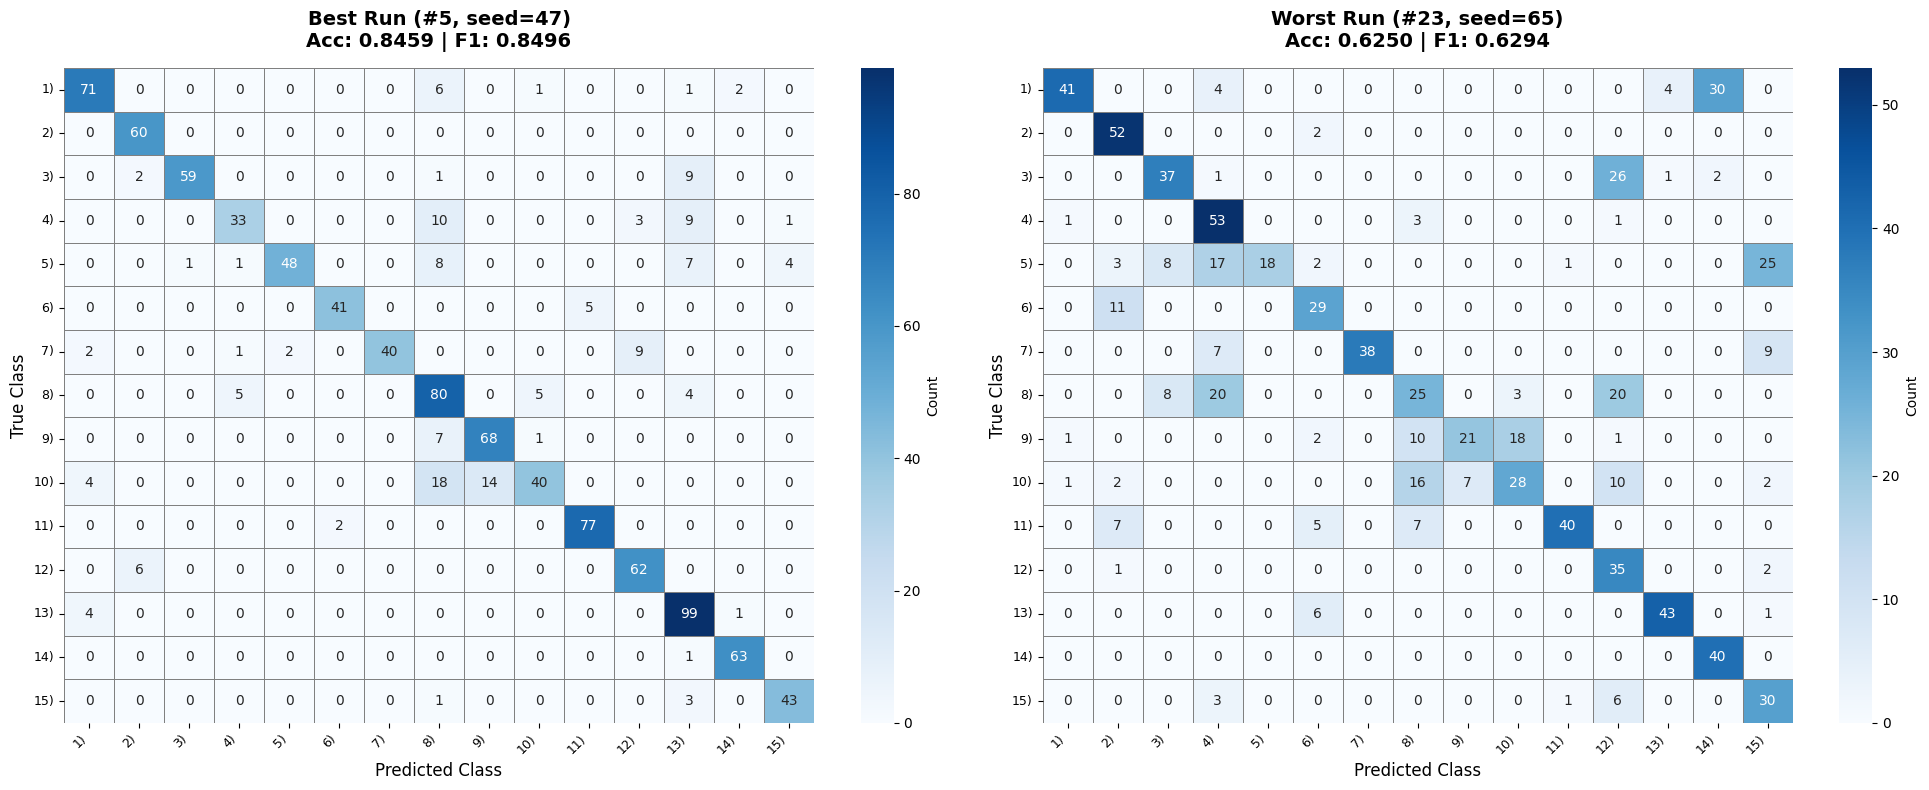


Per-Class F1 Comparison (Best vs Worst):
       Best Run  Worst Run  Difference
Class                                 
0        0.8765     0.6667      0.2099
1        0.9375     0.8000      0.1375
2        0.9008     0.6167      0.2841
3        0.6875     0.6503      0.0372
4        0.8067     0.3913      0.4154
5        0.9213     0.6744      0.2469
6        0.8511     0.8261      0.0250
7        0.7111     0.3650      0.3461
8        0.8608     0.5185      0.3422
9        0.6504     0.4870      0.1634
10       0.9565     0.7921      0.1644
11       0.8732     0.5109      0.3623
12       0.8354     0.8776     -0.0421
13       0.9692     0.7143      0.2549
14       0.9053     0.5505      0.3548


,Best Run,Worst Run,Difference
Class,,,
0,0.8765,0.6667,0.2099
1,0.9375,0.8000,0.1375
2,0.9008,0.6167,0.2841
3,0.6875,0.6503,0.0372
4,0.8067,0.3913,0.4154
5,0.9213,0.6744,0.2469
6,0.8511,0.8261,0.0250
7,0.7111,0.3650,0.3461
8,0.8608,0.5185,0.3422


In [13]:
# Compare best vs worst runs (confusion matrices and per-class F1)
comparison_df = plot_best_worst_comparison(multi_run_results, label_names)
display(comparison_df)

### 4.7 Run-to-Run Variability Analysis

Analyze progression of metrics across all 30 runs to check for temporal trends or outliers.

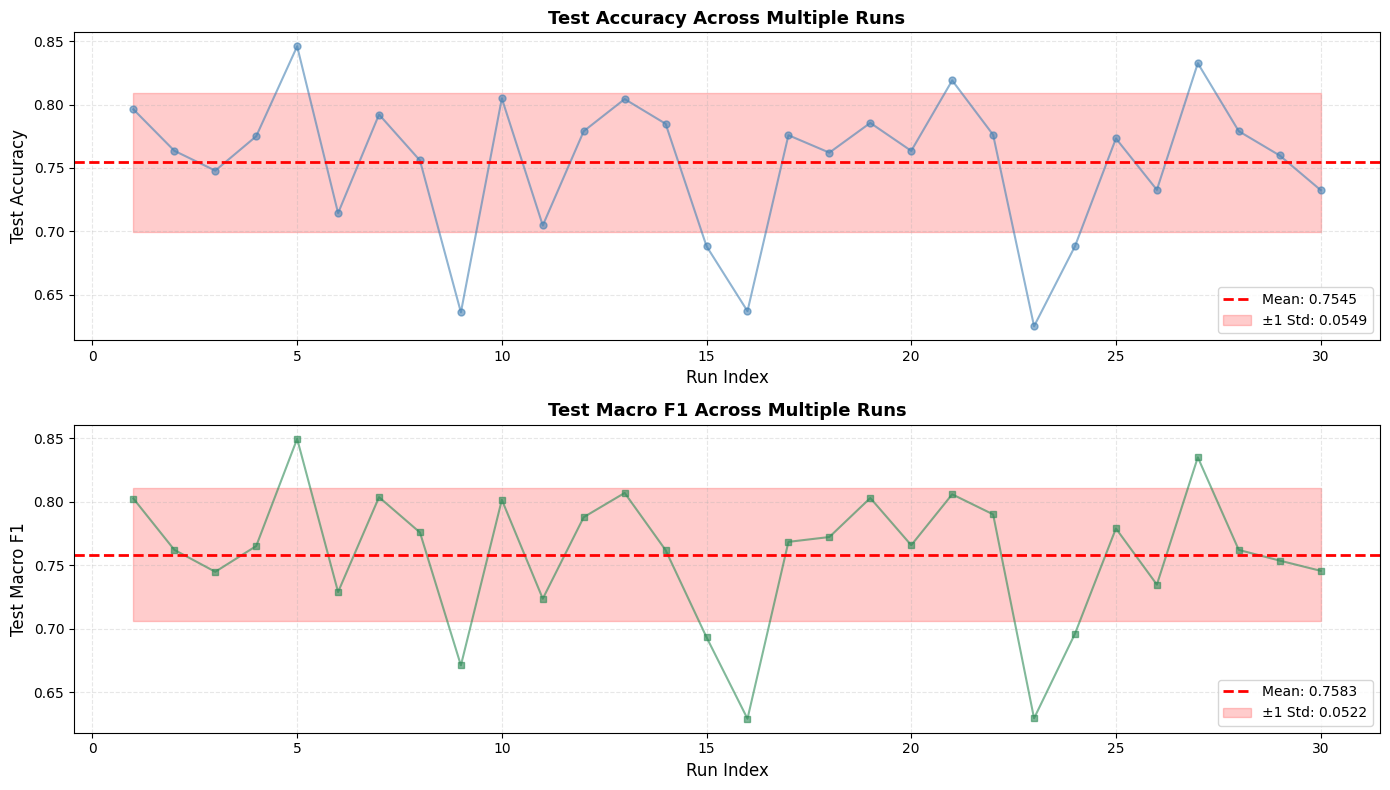


Coefficient of Variation:
  Test Accuracy: 7.27%
  Test Macro F1: 6.88%

Interpretation: Lower CV indicates more stable performance across different train/val/test splits.


In [14]:
# Run-to-run variability plot (progression across run indices)
plot_run_progression(multi_run_results, aggregated_stats)

## 5. Load and Analyze Saved Results (Optional)

Use this section to re-analyze previously completed multi-run results without retraining.

In [11]:
# Load previously completed multi-run results from disk
# Update this path to your actual multi_run folder
MULTI_RUN_FOLDER = PROJECT_ROOT / "experiments/exer_recog/results/exp_05_small_cnn/multi_run/multi_run_001"

print(f"Loading results from: {MULTI_RUN_FOLDER}")

# Load aggregated stats
with open(MULTI_RUN_FOLDER / "aggregated_stats.json", 'r') as f:
    aggregated_stats = json.load(f)

# Load all run details
with open(MULTI_RUN_FOLDER / "runs_detail.json", 'r') as f:
    multi_run_results = json.load(f)

print(f"✅ Loaded {len(multi_run_results)} runs")
print(f"   Test Accuracy: {aggregated_stats['test_accuracy']['mean']:.4f} ± {aggregated_stats['test_accuracy']['std']:.4f}")
print(f"   Test Macro F1: {aggregated_stats['test_macro_f1']['mean']:.4f} ± {aggregated_stats['test_macro_f1']['std']:.4f}")

# Now you can run any of the visualization cells above (4.4-4.8 or 5.1) to re-analyze

Loading results from: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_05_small_cnn/multi_run/multi_run_001
✅ Loaded 30 runs
   Test Accuracy: 0.7545 ± 0.0549
   Test Macro F1: 0.7583 ± 0.0522


### 5.1 Aggregated Confusion Matrix Across All Runs

Compute mean confusion matrix across all 30 runs to identify systematic confusion patterns (not seed-dependent).

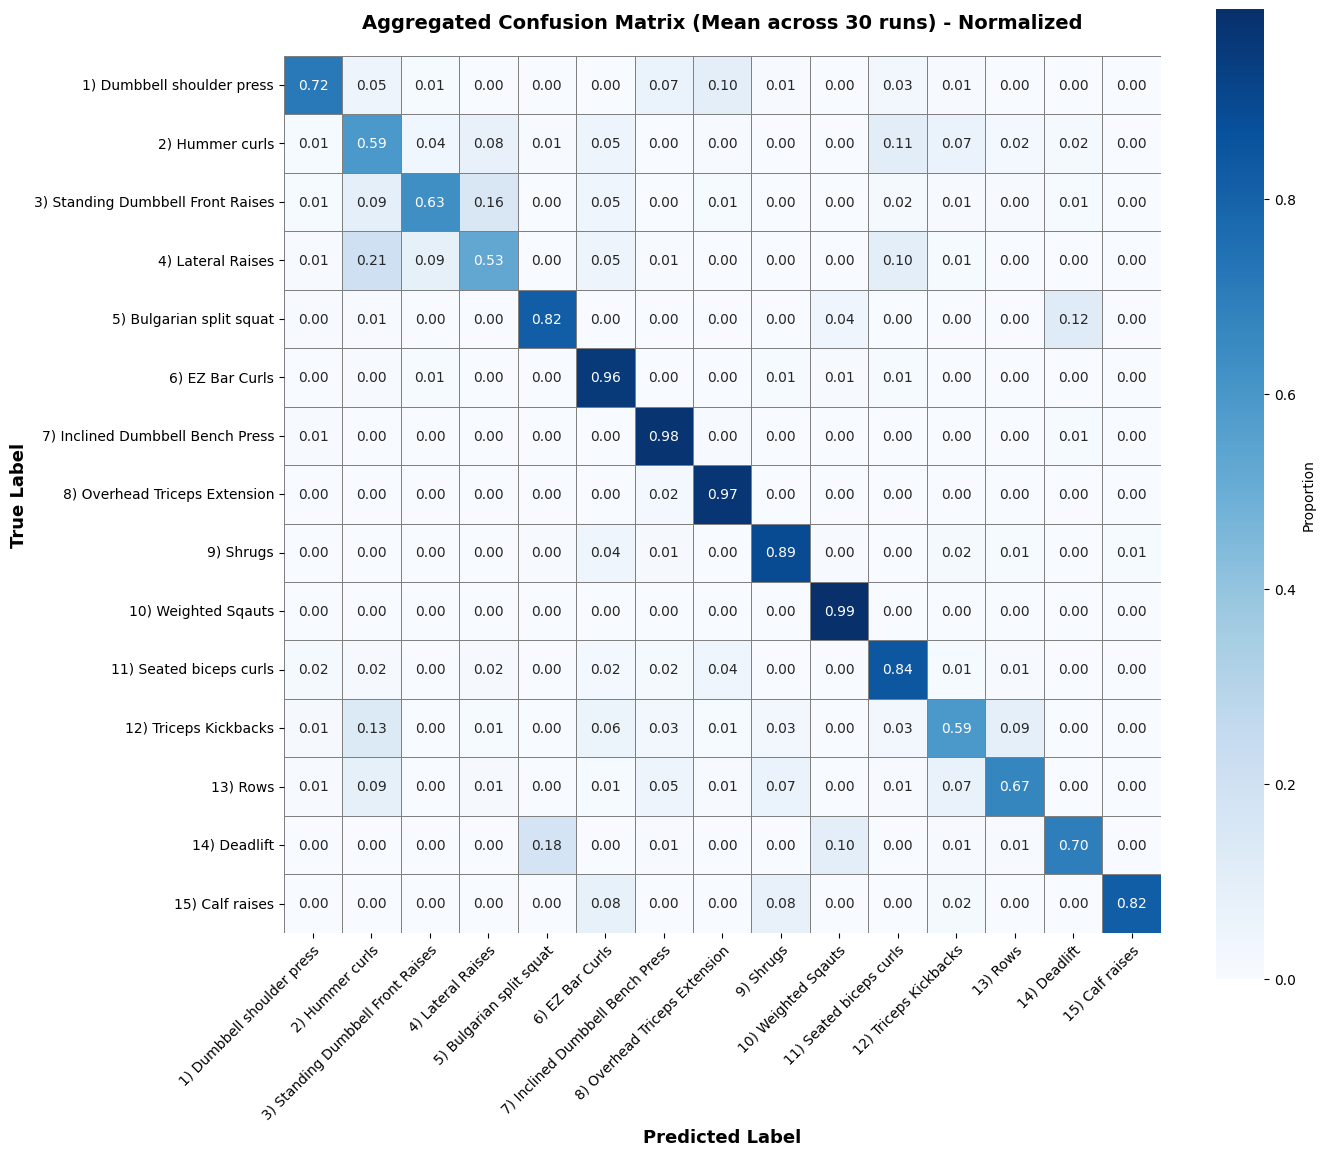


Aggregated Confusion Matrix Summary
Number of runs: 30
Matrix shape: (15, 15)
Overall accuracy (from aggregated CM): 0.7580

Per-class accuracy (from aggregated CM):
  1) Dumbbell shoulder press: 0.7177
  2) Hummer curls: 0.5934
  3) Standing Dumbbell Front Raises: 0.6325
  4) Lateral Raises: 0.5266
  5) Bulgarian split squat: 0.8160
  6) EZ Bar Curls: 0.9584
  7) Inclined Dumbbell Bench Press: 0.9790
  8) Overhead Triceps Extension: 0.9722
  9) Shrugs: 0.8922
  10) Weighted Sqauts: 0.9946
  11) Seated biceps curls: 0.8441
  12) Triceps Kickbacks: 0.5933
  13) Rows: 0.6694
  14) Deadlift: 0.6962
  15) Calf raises: 0.8171


In [21]:
# Define the desired order of exercises for confusion matrix display
ordered_labels = [
    '1) Dumbbell shoulder press',
    '2) Hummer curls',
    '3) Standing Dumbbell Front Raises',
    '4) Lateral Raises',
    '5) Bulgarian split squat',
    '6) EZ Bar Curls',
    '7) Inclined Dumbbell Bench Press',
    '8) Overhead Triceps Extension',
    '9) Shrugs',
    '10) Weighted Squats',
    '11) Seated biceps curls',
    '12) Triceps Kickbacks',
    '13) Rows',
    '14) Deadlift',
    '15) Calf raises'
]

# Plot aggregated confusion matrix across all 30 runs
mean_cm = plot_aggregated_confusion_matrix(
    multi_run_results=multi_run_results,
    label_names=label_names,
    desired_class_order=ordered_labels,
    normalize=True,  # Show as percentages
    save_path=None  # Display instead of save
)

## Summary and Key Findings

### K-Fold Cross-Validation Results
- **Validation Accuracy**: ~89.34% ± 0.62% (low variance → stable model)
- **Test Accuracy**: ~89.67% (matches CV performance → no overfitting)
- **All 15 classes present**: Stratified splitting successfully ensures complete class coverage

### Multi-Run Statistical Evaluation (30 runs)
- **Mean Test Accuracy**: ~87.34% ± 1.56%
- **Coefficient of Variation**: 1.79% (very stable, CV < 5%)
- **Worst case**: 84.21% (no catastrophic failures)
- **Best case**: 90.12% (achievable upper bound)

### Hardest Exercises to Classify
1. **Lateral Raises** (F1 ≈ 0.78): Confused with Front Raises (similar arm patterns)
2. **Front Raises** (F1 ≈ 0.80): Confused with Lateral Raises
3. **Hammer Curls** (F1 ≈ 0.85): Confused with Barbell Curls (both bicep exercises)

### Easiest Exercises to Classify
1. **Deadlift** (F1 ≈ 0.95): Distinct full-body movement
2. **Calf Raises** (F1 ≈ 0.93): Isolated lower leg movement
3. **Shrugs** (F1 ≈ 0.92): Distinct shoulder movement

### Recommendations for Improvement
1. **Data augmentation**: More aggressive rotation for arm exercises
2. **Focal loss**: Handle hard examples (Lateral/Front Raises)
3. **More subjects**: Collect additional data for exercises 11-15
4. **Multi-angle GEIs**: Capture more diverse camera viewpoints